In [1]:
import sys
import os

import torch
import random
import warnings
import time

import torch.nn as nn
import torch.multiprocessing as mp
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from scipy.ndimage import gaussian_filter1d
from tqdm.auto import tqdm
from itertools import product

warnings.filterwarnings("ignore")

# Import MI files
from utils import *
from models import *
from estimators import *
from trainers import *
from datatools import *

plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams['figure.dpi'] = 100

# Set global font sizes for better readability
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'axes.titlesize': 18})
plt.rcParams.update({'axes.labelsize': 16})
plt.rcParams.update({'xtick.labelsize': 15})
plt.rcParams.update({'ytick.labelsize': 15})
plt.rcParams.update({'legend.fontsize': 15})

# Set defaults, device
default_dtype = torch.float32
torch.set_default_dtype(default_dtype)
if torch.cuda.is_available():
    device = 'cuda'
    synchronize = torch.cuda.synchronize
    empty_cache = torch.cuda.empty_cache
elif torch.backends.mps.is_available():
    device = 'mps'
    synchronize = torch.mps.synchronize
    empty_cache = torch.mps.empty_cache
else:
    device = "CPU"
    synchronize = lambda: None
    empty_cache = lambda: None

# Directories
main_dir = os.getcwd()
data_dir = os.path.join(main_dir, '..', '..', 'localdata')
model_cache_dir = os.path.join(data_dir, 'model_cache')
os.makedirs(model_cache_dir, exist_ok=True)
result_dir = os.path.join(data_dir, 'estimation_runs')
os.makedirs(result_dir, exist_ok=True)

/Users/leo/Desktop/ResearchPhD/VNCMP/analysis_VNCMP/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ds = TimeWindowDatasetKinematics(os.path.join(data_dir, '2025-02-25_1'), window_size=0.05, neuron_label_filter=1, use_ISI=True, time_offset=0.049, only_valid_kinematics=True)#, select_x=[10])

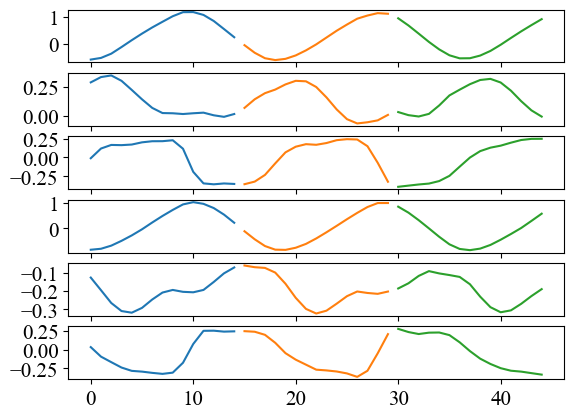

In [14]:
Zmain = ds.Zmain.detach().clone().cpu().numpy()
ind = np.random.choice(np.unique(np.where(Zmain)[0]))
fig, ax = plt.subplots(6,1)
for i in range(6):
    ax[i].plot(np.arange(0, 15), Zmain[ind,i,:])
    ax[i].plot(np.arange(15, 30), Zmain[ind+1,i,:])
    ax[i].plot(np.arange(30, 45), Zmain[ind+2,i,:])

In [11]:
Zmain[5162,1,:]


array([0.80991614, 0.80693537, 0.8099057 , 0.80816525, 0.80700946,
       0.80753034, 0.81054676, 0.8076813 , 0.81189275, 0.8140804 ,
       0.8087525 , 0.8032422 , 0.80838823, 0.8055744 , 0.8087469 ],
      dtype=float32)

In [2]:
base_name = os.path.join(data_dir, '2025-02-25_1')
kinematics_file = f"{base_name}_kinematics.npz"
if os.path.exists(kinematics_file):
    kine_data = np.load(kinematics_file)

In [15]:
kine_names = list(kine_data.keys())
kine_data['index'].max()

59606250

In [5]:
np.searchsorted(ds.window_times, ds.Ztimes, side='right') - 1

array([ 5161,  5161,  5161, ..., 22515, 22515, 22515])

In [9]:
monotonic_repeats_to_ranges(np.searchsorted(ds.window_times, ds.Ztimes, side='right') - 1)

array([   0,    1,    2, ..., 2618, 2619, 2620])

In [15]:
window_inds_z = np.searchsorted(ds.window_times, ds.Ztimes, side='right') - 1
vals, lens = np.unique(window_inds_z, return_counts=True)
np.unique(lens)

array([    5,    15,  1459,  1577,  1695,  1939,  1990,  2175,  2621,
        2792,  2839,  2956,  3671,  4078,  4471,  5212,  5256,  5550,
        5819,  6175,  7294,  8475, 12354, 12549, 13419, 13924, 14881])

In [10]:
np.where(lens > 15)

(array([  125,   641,  1170,  1740,  1894,  2563,  3016,  4010,  4654,
         5405,  5927,  6448,  7013,  7323,  7719,  8443,  8711,  9068,
         9641,  9877, 10183, 10748, 11161, 11604, 11981]),)

In [16]:
window_inds_z[window_inds_z == vals[125]]

array([5286, 5286, 5286, ..., 5286, 5286, 5286])

In [25]:
ind = np.arange(5285,5289)
print(ds.window_times[ind])
kinedif = np.diff(ds.window_times)
kinevalid = np.diff(ds.window_times) < (ds.window_size + np.finfo(np.float32).eps)
print(ds.valid_window[ind])
print(kinedif[ind])
print(kinevalid[ind])

[384.75213333 384.80213333 429.53226667 429.58226667]
[ True  True  True  True]
[ 0.05       44.73013333  0.05        0.05      ]
[ True False  True  True]


Epoch: 1, DSIB, test: 0.005901995114982128
Epoch: 2, DSIB, test: -0.020424991846084595
Epoch: 3, DSIB, test: -0.011384022422134876
Epoch: 4, DSIB, test: -0.006396844983100891
Epoch: 5, DSIB, test: 0.006019046064466238
Epoch: 6, DSIB, test: -0.03389984369277954
Epoch: 7, DSIB, test: -0.01702205277979374
Epoch: 8, DSIB, test: -0.00705272052437067
Epoch: 9, DSIB, test: -0.005090669263154268
Epoch: 10, DSIB, test: -0.00434656860306859
Epoch: 11, DSIB, test: -0.014588901773095131
Epoch: 12, DSIB, test: 0.0014322542119771242
Epoch: 13, DSIB, test: 0.006625804118812084
Epoch: 14, DSIB, test: -0.013557825237512589
Epoch: 15, DSIB, test: -0.0023385982494801283
Epoch: 16, DSIB, test: -0.01383969746530056
Epoch: 17, DSIB, test: 0.004565132316201925
Epoch: 18, DSIB, test: 0.013977142982184887
Epoch: 19, DSIB, test: 0.007846306078135967
Epoch: 20, DSIB, test: 0.008082780987024307
Epoch: 21, DSIB, test: 0.010419758036732674
Epoch: 22, DSIB, test: 0.021840348839759827
Epoch: 23, DSIB, test: -0.010258

(0.0, 0.22124315686523915)

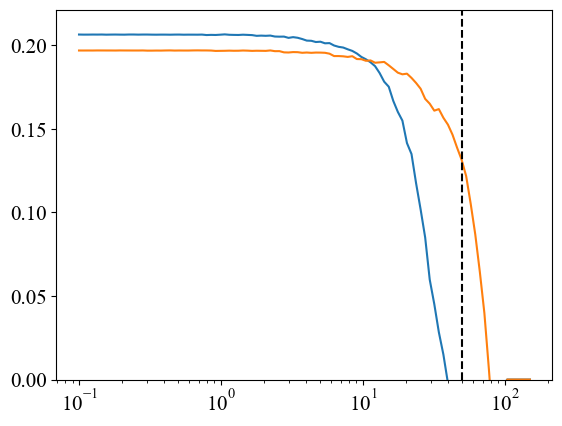

In [5]:
params = {
    # Optimizer parameters (for training)
    'epochs': 300,
    'window_size': 0.05,
    # 'batch_size': 512, # Number of windows estimator processes at any time
    's_per_batch': 30, # Alternatively specify seconds of data a batch should be
    'learning_rate': 5e-3,
    'patience': 50,
    'min_delta': 0.001,
    'eps': 1e-8, # Use 1e-4 if dtypes are float16, 1e-8 for float32 works okay
    'train_fraction': 0.95,
    'n_test_set_blocks': 5, # Number of contiguous blocks of data to dedicate to test set
    'epochs_till_max_shift': 10, # Number of epochs until random shifting is at max
    'model_cache_dir': model_cache_dir,
    # Critic parameters for the estimator
    'model_func': DSIB, # DSIB or DVSIB
    'activation': nn.PReLU,
    'layers': 3,
    'hidden_dim': 128,
    'embed_dim': 6,
    'use_bias': False,
    'beta': 512, # Just used in DVSIB
    'estimator': 'infonce', # Estimator: infonce or smile_5. See estimators.py for all options
    'mode': 'sep', # Almost always we'll use separable
    'max_n_batches': 256, # If input has more than this many batches, encoder runs are split up for memory management
}
precision_levels = np.hstack((0, np.logspace(np.log10(0.0001), np.log10(0.15), 100)))

# ISI
ds = TimeWindowDataset(os.path.join(data_dir, '2025-03-11'), window_size=params['window_size'], neuron_label_filter=1, use_ISI=True, select_x=[10])
this_params = {**params, 'X_dim': ds.X.shape[1] * ds.X.shape[2], 'Y_dim': ds.Y.shape[1] * ds.Y.shape[2]}

mis_test, train_id = train_model_no_eval(ds, this_params)
model = retrieve_best_model(mis_test, this_params, train_id=train_id, remove_all=True)
mi = precision_rounding(precision_levels, ds, model)

# No ISI
ds = TimeWindowDataset(os.path.join(data_dir, '2025-03-11'), window_size=params['window_size'], neuron_label_filter=1, use_ISI=False, select_x=[10])
this_params = {**params, 'X_dim': ds.X.shape[1] * ds.X.shape[2], 'Y_dim': ds.Y.shape[1] * ds.Y.shape[2]}

mis_test, train_id = train_model_no_eval(ds, this_params)
model_reg = retrieve_best_model(mis_test, this_params, train_id=train_id, remove_all=True)
mi_reg = precision_rounding(precision_levels, ds, model_reg)

plt.plot(precision_levels * 1000, mi[1:])
plt.plot(precision_levels * 1000, mi_reg[1:])
plt.axvline(this_params['window_size'] * 1000, color='k', linestyle='--')
plt.gca().set_xscale('log')
plt.gca().set_ylim(0)

In [5]:
mi = np.zeros_like(precision_levels)
with torch.no_grad():
    for i,prec in enumerate(precision_levels):
        ds.apply_precision(prec)
        mi[i] = - model(ds.X, ds.Y).detach().cpu().numpy()
        print(mi[i])


0.46624115109443665
0.46624115109443665
0.46624115109443665
0.46624115109443665
0.46624115109443665
0.46624115109443665
0.46624115109443665
0.46624115109443665
0.46624115109443665
0.46624115109443665
0.46624115109443665
0.46624115109443665
0.46624115109443665
0.46624115109443665
0.46624115109443665
0.46624115109443665
0.46624115109443665
0.46624115109443665
0.46624115109443665
0.46624115109443665
0.46624115109443665
0.46624115109443665
0.46624115109443665
0.46624115109443665
0.46624115109443665
0.46624115109443665
0.46624115109443665
0.46624115109443665
0.46624115109443665
0.46624115109443665
0.46624115109443665
0.46624115109443665
0.46624115109443665
0.46624115109443665
0.46624115109443665
0.46624115109443665
0.46624115109443665
0.46624115109443665
0.46624115109443665
0.46624115109443665
0.46624115109443665
0.46624115109443665
0.46624115109443665
0.46624115109443665
0.46624115109443665
0.46624115109443665
0.46624115109443665
0.46624115109443665
0.46624115109443665
0.46624115109443665


(array([2., 0., 3., 1., 2., 1., 0., 0., 0., 1.]),
 array([1.10430193, 1.12148631, 1.13867056, 1.15585494, 1.17303932,
        1.19022369, 1.20740795, 1.22459233, 1.2417767 , 1.25896096,
        1.27614534]),
 <BarContainer object of 10 artists>)

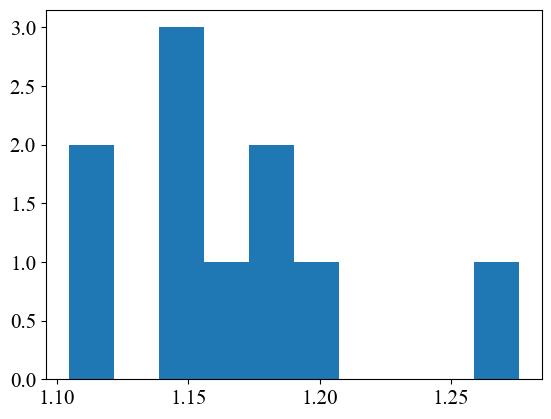

In [7]:
plt.hist(np.array(mi))

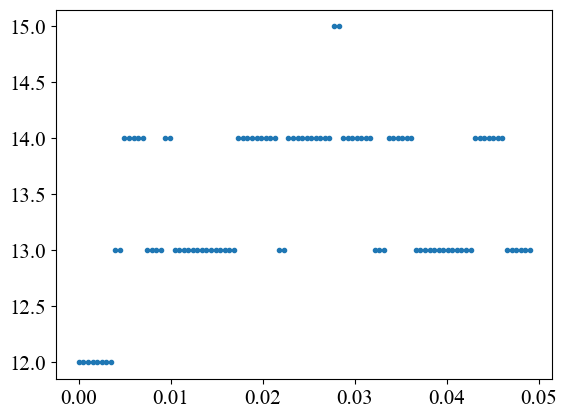

In [ ]:
offsets = np.linspace(0, 0.049, 100)
nwind = np.zeros_like(offsets)
ds = TimeWindowDataset(os.path.join(data_dir, '2025-03-11'), window_size=0.05, neuron_label_filter=1, time_offset=0)
for i,off in enumerate(offsets):
    ds.move_data_to_windows(time_offset=off)
    # nwind[i] = ds.n_windows
    nwind[i] = ds.X.shape[2]
plt.plot(offsets, nwind, '.')

In [52]:
from itertools import islice
def chunk(it, size):
    it = iter(it)
    return iter(lambda: tuple(islice(it, size)), ())

In [55]:
hidden_dim_range = np.array([32, 64, 128, 256, 512])
window_size_range = np.logspace(np.log10(0.02), np.log10(1.0), 10)
main_iterator = product(hidden_dim_range, window_size_range)

chunk_iter = chunk(product([0,1,2,3,4], ['a','b','c','d']), 2)
for i in chunk_iter:
    print(i)
    print('')

((0, 'a'), (0, 'b'))

((0, 'c'), (0, 'd'))

((1, 'a'), (1, 'b'))

((1, 'c'), (1, 'd'))

((2, 'a'), (2, 'b'))

((2, 'c'), (2, 'd'))

((3, 'a'), (3, 'b'))

((3, 'c'), (3, 'd'))

((4, 'a'), (4, 'b'))

((4, 'c'), (4, 'd'))



In [21]:
# Get normal precision curve
# precision_noise_levels = np.hstack((0, np.logspace(np.log10(0.002), np.log10(0.15), 40)))
precision_noise_levels = np.hstack((0, np.logspace(np.log10(2 * np.finfo(np.float32).eps), np.log10(0.15), 50)))
n_repeats = 3
precision_normal = precision(precision_noise_levels, ds, model, n_repeats=n_repeats)

# precision_levels = np.array([0.02, 0.04, 0.06, 0.08, 0.1, 0.12])
# precision_levels = np.linspace(0.001, 0.15, 50)
prec_curves = []
for prec in precision_noise_levels:
    ds.move_data_to_windows()
    ds.apply_precision(prec)
    prec_curves.append(precision(precision_noise_levels, ds, model, n_repeats=n_repeats))

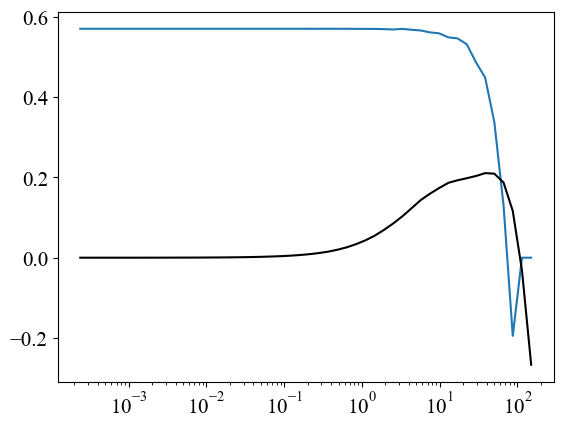

In [24]:
fig, ax = plt.subplots()
ax.plot(precision_noise_levels * 1000, np.array([p[0,:].mean() for p in prec_curves]))
ax.plot(precision_noise_levels[1:] * 1000, precision_normal[1:,:].mean(axis=1), color='k')
ax.set_xscale('log')

0.5417467355728149
expected - actual zero noise MI: -0.34018486738204956
0.437033474445343
expected - actual zero noise MI: -0.2219697137673696
0.21179932355880737
expected - actual zero noise MI: -0.0203293114900589
-0.07800589501857758
expected - actual zero noise MI: 0.19445889194806415
-0.02238442562520504
expected - actual zero noise MI: 0.13883742255469161
-6.41125623701555e-08
expected - actual zero noise MI: -0.025899744430861443


(0.0, 0.6012426982323329)

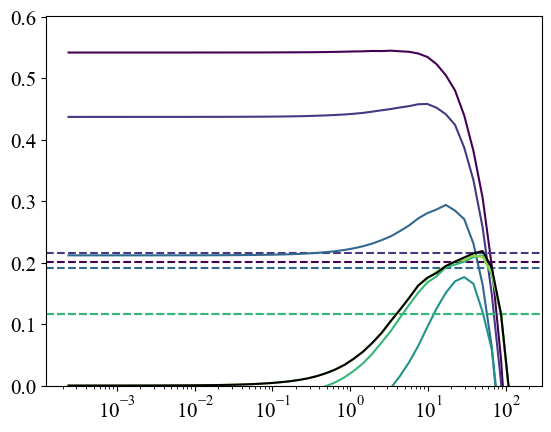

In [14]:
import matplotlib.cm as cm
cmap = plt.cm.viridis
fig, ax = plt.subplots()
for i, prec in enumerate(precision_levels):
    color = cmap(i/len(precision_levels))
    ax.plot(precision_noise_levels[1:] * 1000, prec_curves[i][1:,:].mean(axis=1), color=color)
    ind = np.argmin(np.abs(precision_noise_levels - prec))
    ax.axhline(precision_normal[ind,:].mean(), color=color, linestyle='--')
    print(prec_curves[i][0,:].mean())
    print(f'expected - actual zero noise MI: {precision_normal[ind,:].mean() - prec_curves[i][0,:].mean()}')
ax.plot(precision_noise_levels[1:] * 1000, precision_normal[1:,:].mean(axis=1), color='k')
ax.set_xscale('log')
ax.set_ylim(0)

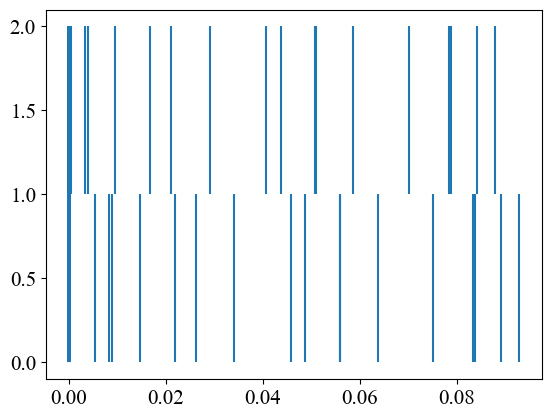

In [ ]:
ds = TimeWindowDataset(os.path.join(data_dir, '2025-03-11'), window_size=0.1, neuron_label_filter=1)
i = np.random.choice(ds.n_windows)
i = 0 
plt.vlines(ds.X[i,:,:].detach().cpu().numpy().flatten(), ymin=0, ymax=1)
ds.move_data_to_windows(time_offset=0.005)
# ds.apply_precision(0.001)
plt.vlines(ds.X[i,:,:].detach().cpu().numpy().flatten(), ymin=1, ymax=2)

In [58]:
precision_noise_levels = np.hstack((0, np.logspace(np.log10(0.002), np.log10(0.1), 30)))
n_repeats = 50

with torch.no_grad():
    synchronize()
    tic = time.time()
    mi = - model(ds.X, ds.Y).detach().cpu().numpy()
    synchronize()
    print(f'DSIB Inference: {time.time() - tic}')
    print(f'DSIB MI: {mi}')

    synchronize()
    tic = time.time()
    mi = model_DVSIB(ds.X, ds.Y)[2].detach().cpu().numpy()
    synchronize()
    print(f'DVSIB Inference: {time.time() - tic}')
    print(f'DVSIB MI: {mi}')

DSIB Inference: 0.029646873474121094
DSIB MI: 0.13518087565898895
DVSIB Inference: 0.06697607040405273
DVSIB MI: -0.0037905958015471697


Precision DSIB: 14.712713956832886, 0.009808475971221925 s/iteration


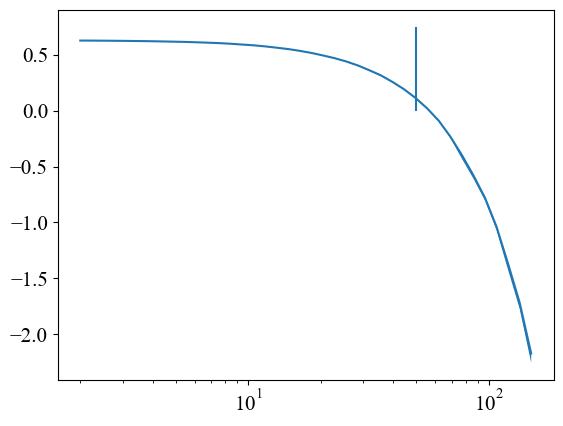

In [ ]:
precision_noise_levels = np.hstack((0, np.logspace(np.log10(0.002), np.log10(0.15), 40)))
n_repeats = 15

synchronize()
tic = time.time()
precision_mi = precision(precision_noise_levels, ds, model, n_repeats=n_repeats)
synchronize()
final_time = time.time() - tic
print(f'Precision DSIB: {final_time}, {final_time / 1500} s/iteration')

fig, ax = plt.subplots()
mean_sig, sd_sig = precision_mi[1:].mean(axis=1), precision_mi[1:].std(axis=1)
ax.plot(precision_noise_levels[1:] * 1000, mean_sig)
ax.fill_between(precision_noise_levels[1:] * 1000, mean_sig, mean_sig - sd_sig, mean_sig + sd_sig)
ax.vlines(0.05 * 1000, ymin=0, ymax=0.75)

# mean_sig, sd_sig = precision_mi_dvsib[1:].mean(axis=1), precision_mi_dvsib[1:].std(axis=1)
# ax.plot(precision_noise_levels[1:] * 1000, mean_sig)
# ax.fill_between(precision_noise_levels[1:] * 1000, mean_sig, mean_sig - sd_sig, mean_sig + sd_sig)
ax.set_xscale('log')

Epoch: 1, DSIB, test: 0.0010268732439726591
Epoch: 2, DSIB, test: 0.002406772691756487
Epoch: 3, DSIB, test: 0.006818594876676798
Epoch: 4, DSIB, test: 0.009204505011439323
Epoch: 5, DSIB, test: 0.009548758156597614
Epoch: 6, DSIB, test: 0.009588584303855896
Epoch: 7, DSIB, test: 0.00992280337959528
Epoch: 8, DSIB, test: 0.01063374150544405
Epoch: 9, DSIB, test: 0.01892518810927868
Epoch: 10, DSIB, test: 0.02203366532921791
Epoch: 11, DSIB, test: 0.02065541222691536
Epoch: 12, DSIB, test: 0.023500708863139153
Epoch: 13, DSIB, test: 0.020510133355855942
Epoch: 14, DSIB, test: 0.02380509488284588
Epoch: 15, DSIB, test: 0.023576099425554276
Epoch: 16, DSIB, test: 0.023562096059322357
Epoch: 17, DSIB, test: 0.024489471688866615
Epoch: 18, DSIB, test: 0.01692551001906395
Epoch: 19, DSIB, test: 0.02559858001768589
Epoch: 20, DSIB, test: 0.02122385986149311
Epoch: 21, DSIB, test: 0.024122940376400948
Epoch: 22, DSIB, test: 0.024644149467349052
Epoch: 23, DSIB, test: 0.02335401251912117
Epoch:

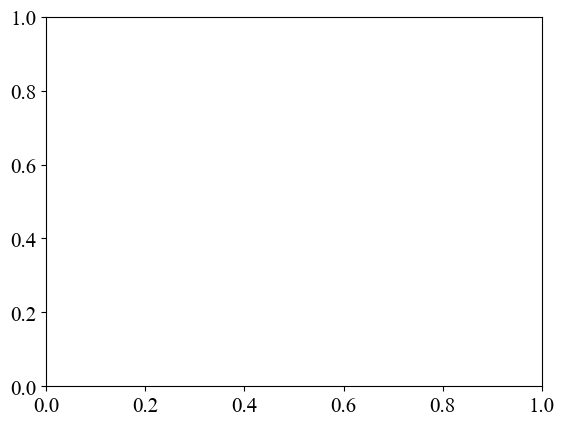

In [ ]:
params = {
    # Optimizer parameters (for training)
    'epochs': 250,
    'window_size': 0.05,
    'batch_size': 1024, # Number of windows estimator processes at any time
    'learning_rate': 5e-3,#5e-3,
    'patience': 50,
    'min_delta': 0.001,
    'eps': 1e-8, # Use 1e-4 if dtypes are float16, 1e-8 for float32 works okay
    'train_fraction': 0.9,
    'model_cache_dir': model_cache_dir,
    # Critic parameters for the estimator
    'model_func': DSIB, # DSIB or DVSIB
    'layers': 3,
    'hidden_dim': 128,#512,
    'activation': nn.LeakyReLU, #nn.Softplus
    'embed_dim': 6,#10,
    'beta': 1024, #512
    'estimator': 'infonce', # Estimator: infonce or smile_5. See estimators.py for all options
    'mode': 'bi', # Almost always we'll use separable
    'max_n_batches': 256, # If input has more than this many batches, encoder runs are split up for memory management
}
precision_noise_levels = np.hstack((0, np.logspace(np.log10(0.002), np.log10(0.15), 40)))
n_repeats = 15

window_range = np.array([0.02, 0.06, 0.1])

precision_mi = []

for window in window_range:
    ds = TimeWindowDataset(os.path.join(data_dir, '2025-03-11'), window_size=window, neuron_label_filter=1, select_x=[10])

    this_params = {**params, 'X_dim': ds.X.shape[1] * ds.X.shape[2], 'Y_dim': ds.Y.shape[1] * ds.Y.shape[2], 'patience': 20}

    mis_test, train_id = train_model_no_eval(ds, this_params)
    model = retrieve_best_model(mis_test, this_params, train_id=train_id, remove_all=True)

    precision_mi.append(precision(precision_noise_levels, ds, model, n_repeats=n_repeats))

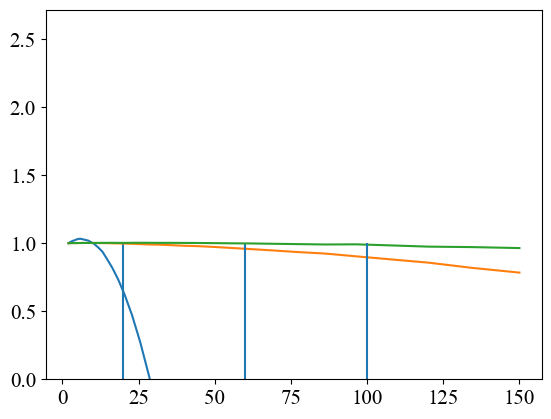

In [23]:
fig, ax = plt.subplots()
for i,window in enumerate(window_range):    
    mean_sig, sd_sig = precision_mi[i][1:].mean(axis=1), precision_mi[i][1:].std(axis=1)
    ax.plot(precision_noise_levels[1:] * 1000, mean_sig / mean_sig[0])
    # ax.fill_between(precision_noise_levels[1:] * 1000, mean_sig, mean_sig - sd_sig, mean_sig + sd_sig)
    ax.vlines(window * 1000, ymin=0, ymax=1)
    ax.set_ylim(0)

2.1818389892578125
Neurons (X): torch.Size([12, 4759184])
Muscles (Y): torch.Size([10, 4759184])
Neuron Labels: ['12', '25', '22', '11', '5', '75', '27', '16', '44', '45', '17', '9']
Muscle Labels: ['rsa', 'rdvm', 'lba', 'ldvm', 'rdlm', 'lsa', 'rax', 'lax', 'rba', 'ldlm']


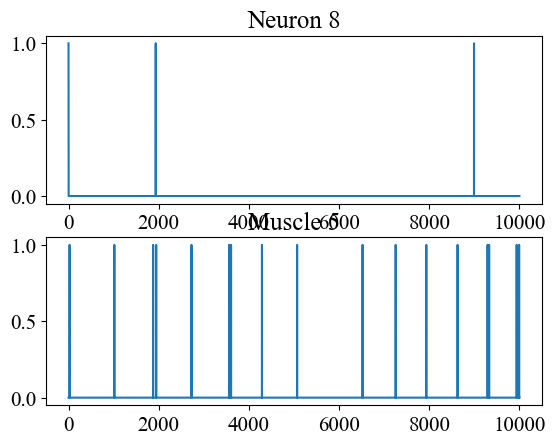

In [6]:
# Read the data and apply some binning/downsampling
period = 0.0001
tic = time.time()
X, Y, x_labels, y_labels, bout_starts = read_spike_data(os.path.join(data_dir, '2025-03-11'), period, neuron_label_filter=1)
print(time.time() - tic)

print(f"Neurons (X): {X.shape}")
print(f"Muscles (Y): {Y.shape}") 
print("Neuron Labels:", x_labels)
print("Muscle Labels:", y_labels)

# Plot sample of activity
pl = 10000
useneuron, usemuscle = np.random.choice(X.shape[0]), np.random.choice(Y.shape[0])
useneuron = 8
idx = torch.nonzero(X[useneuron,:])[0][0]
fig, ax = plt.subplots(2, 1)
ax[0].plot(X[useneuron,idx:idx+pl].cpu())
ax[1].plot(Y[usemuscle,idx:idx+pl].cpu())
ax[0].set_title(f'Neuron {useneuron}')
ax[1].set_title(f'Muscle {usemuscle}')
fig.show()

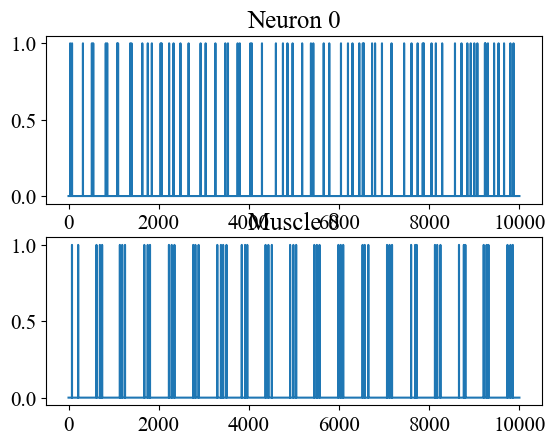

In [22]:
pl = 10000
useneuron, usemuscle = np.random.choice(X.shape[0]), np.random.choice(Y.shape[0])
useneuron = 0
idx = np.random.choice(torch.nonzero(X[useneuron,:]).cpu().flatten())
fig, ax = plt.subplots(2, 1)
idx = idx + 4000
ax[0].plot(X[useneuron,idx:idx+pl].cpu())
ax[1].plot(Y[usemuscle,idx:idx+pl].cpu())
ax[0].set_title(f'Neuron {useneuron}')
ax[1].set_title(f'Muscle {usemuscle}')
fig.show()

In [12]:
params = {
    # Optimizer parameters (for training)
    'epochs': 250,
    'window_size': 256, # Window of time the estimator operates on, in samples
    'batch_size': 128, # Number of windows estimator processes at any time
    'learning_rate': 5e-3,
    'patience': 15,
    'min_delta': 0.001,
    'eps': 1e-8, # Use 1e-4 if dtypes are float16, 1e-8 for float32 works okay
    'train_fraction': 0.9,
    'model_cache_dir': model_cache_dir,
    # Critic parameters for the estimator
    'model_func': DSIB, # DSIB or DVSIB
    'branch': 'expDilation', # Whether to have branched first layer '1', all branched layers 'all', or None if no branch layers
    'stride': 2, # stride of CNN layers. First layer will always be stride=1
    'n_filters': 8, # Number of new filters per layer. Each layer will 2x this number
    'layers': 7,
    'fc_layers': 2, # fully connected layers
    'hidden_dim': 256,
    'activation': nn.LeakyReLU, #nn.Softplus
    'embed_dim': 10,
    'beta': 512,
    'max_dz': 12, # max value for embed_dim that we search for
    'estimator': 'infonce', # Estimator: infonce or smile_5. See estimators.py for all options
    'mode': 'sep', # Almost always we'll use separable
    'max_n_batches': 256, # If input has more than this many batches, encoder runs are split up for memory management
}

0.23917388916015625


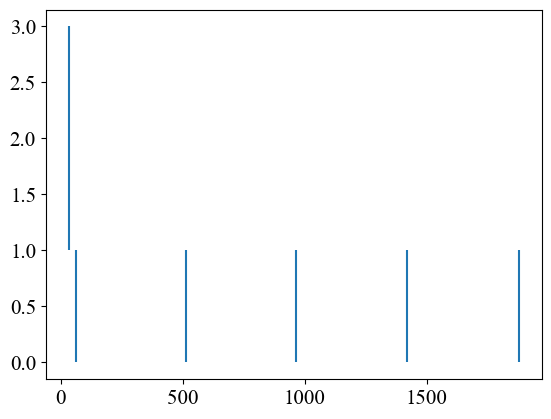

In [4]:
neuron = np.random.choice(X.shape[0])
this_params = {**params, 'embed_dim': 10}
dataset = BatchedDatasetWithNoise(X[[neuron],:], Y, bout_starts, this_params['window_size'], check_activity=True)

fig, ax = plt.subplots(1, 1)

i = np.random.choice(dataset.n_batches)

inds = dataset.batch_indices[i]

ax.vlines(dataset.Y[i,0,1,:].cpu().numpy().nonzero(), 0, 1)
ax.vlines(dataset.X[i,0,:,:].cpu().numpy().nonzero()[1], 1, 2)
ax.vlines(X[neuron, inds[0]:inds[1]].cpu().numpy().nonzero(), 2, 3)

nspike = []
for i in range(dataset.n_batches):
    nspike.append(len(dataset.X[i,0,:,:].cpu().numpy().nonzero()[0]))


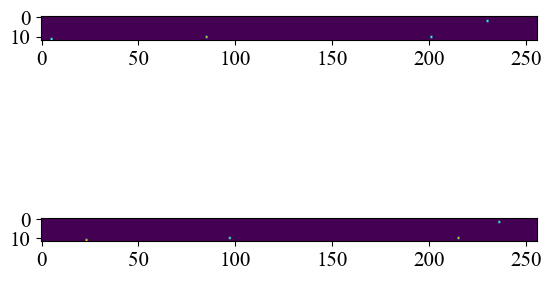

In [119]:
neuron = np.random.choice(X.shape[0])
this_params = {**params, 'embed_dim': 10}
dataset = BatchedDatasetWithNoise(X, Y, bout_starts, this_params['window_size'], check_activity=True)

fig, ax = plt.subplots(2,1)
ax[0].imshow(dataset.X[1,0,:,:].cpu())
dataset.apply_noise(20)
ax[1].imshow(dataset.X[1,0,:,:].cpu())

In [ ]:
torch.mps.empty_cache()
neuron = np.random.choice(X.shape[0])
neuron = 25
print(f'Neuron {neuron}')
this_params = {**params, 'embed_dim': 10}
dataset = BatchedDataset(X[[neuron],:].to(device), Y.to(device), this_params['window_size'])
# mis, mis_test, mod = train_cnn_model(dataset, this_params)
mis_test, train_id = train_model_no_eval(dataset, this_params)
mod = retrieve_best_model(mis_test, this_params, train_id=train_id)


Neuron 25
Train time = 5.775474786758423
Test time = 0.24387192726135254
Epoch: 1, DSIB, test: 0.001490626367740333
Train time = 3.781615972518921
Test time = 0.10401201248168945
Epoch: 2, DSIB, test: 0.0032741264440119267
Train time = 3.767526865005493
Test time = 0.1042170524597168
Epoch: 3, DSIB, test: 0.014530785381793976
Train time = 3.861485004425049
Test time = 0.10765218734741211
Epoch: 4, DSIB, test: 0.06576761603355408
Train time = 3.7685561180114746
Test time = 0.10485291481018066
Epoch: 5, DSIB, test: 0.07053261250257492
Train time = 3.777069091796875
Test time = 0.10352206230163574
Epoch: 6, DSIB, test: 0.07763534039258957
Train time = 3.770236015319824
Test time = 0.10445523262023926
Epoch: 7, DSIB, test: 0.06648082286119461
Train time = 3.7765591144561768
Test time = 0.10422706604003906
Epoch: 8, DSIB, test: 0.046533290296792984
Train time = 3.8732051849365234
Test time = 0.1546030044555664
Epoch: 9, DSIB, test: 0.10662282258272171
Train time = 3.8265159130096436
Test ti

Text(0, 0.5, 'MI')

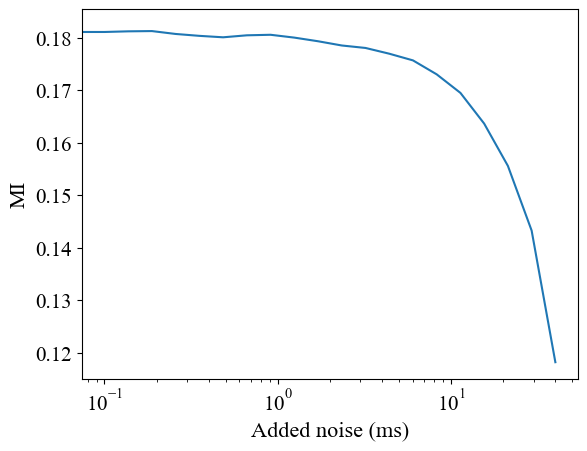

In [6]:
precision_noise_levels = np.hstack((0, np.logspace(np.log10(period), np.log10(0.04), 20) / period))
n_repeats = 3
with torch.no_grad():
    dataset = BatchedDatasetWithNoise(X[[neuron],:].to(device), Y.to(device), this_params['window_size'])
    precision_mi = np.zeros((len(precision_noise_levels), n_repeats))
    for j0,prec_noise_amp in enumerate(precision_noise_levels):
        for j1 in range(n_repeats):
            dataset.apply_noise(prec_noise_amp)
            precision_mi[j0,j1] = - mod(dataset.Xnoise, dataset.Ynoise).detach().cpu().numpy()

fig, ax = plt.subplots()
ax.plot(precision_noise_levels * period * 1000, np.mean(precision_mi, axis=1))
ax.set_xscale('log')
ax.set_xlabel('Added noise (ms)')
ax.set_ylabel('MI')

(0.0, 0.10468171461252496)

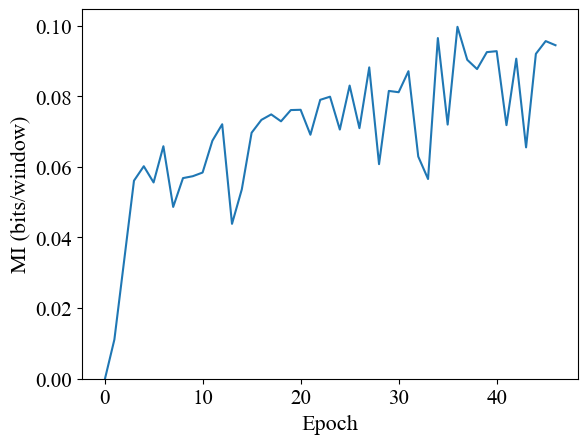

In [7]:
sigma = 1
# plt.plot(mis)
plt.plot(mis_test)
# plt.plot(gaussian_filter1d(mis, sigma=sigma) * np.log2(np.e) / (0.0005 * 512))
# plt.plot(gaussian_filter1d(mis_test, sigma=sigma) * np.log2(np.e) / (0.0005 * 512))
plt.xlabel('Epoch')
plt.ylabel('MI (bits/window)')
plt.ylim(0)

# Try subsampling

In [3]:
params = {
    # Optimizer parameters (for training)
    'epochs': 250,
    'window_size': 512, # Window of time the estimator operates on, in samples
    'batch_size': 128, # Number of windows estimator processes at any time
    'learning_rate': 5e-3,
    'n_trials': 3,
    'patience': 10,
    'min_delta': 0.001,
    'eps': 1e-8, # Use 1e-4 if dtypes are float16, 1e-8 for float32 works okay
    'train_fraction': 0.9,
    'model_cache_dir': model_cache_dir,
    # Critic parameters for the estimator
    'model_func': DSIB, # DSIB or DVSIB
    'branch': 'all', # Whether to have branched first layer '1', all branched layers 'all', or None if no branch layers
    'stride': 2, # stride of CNN layers. First layer will always be stride=1
    'n_filters': 16, # Number of new filters per layer. Each layer will 2x this number
    'layers': 5,
    'fc_layers': 2, # fully connected layers
    'hidden_dim': 256,
    'activation': nn.LeakyReLU, #nn.Softplus
    'embed_dim': 10,
    'beta': 512,
    'max_dz': 12, # max value for embed_dim that we search for
    'estimator': 'infonce', # Estimator: infonce or smile_5. See estimators.py for all options
    'mode': 'sep', # Almost always we'll use separable
    'max_n_batches': 256, # If input has more than this many batches, encoder runs are split up for memory management
}

In [ ]:
neuron = 8
dataset = BatchedDataset(X.to(device), Y.to(device), params['window_size'])

split_sizes = np.arange(1,8)

# Generate random subsample indices
indices = []
for ss in split_sizes:
    inds = np.random.choice(dataset.X.shape[0], dataset.X.shape[0], replace=False)
    edges = np.rint(np.linspace(0, dataset.X.shape[0]-1, ss+1)).astype(int)
    for i in range(ss):
        indices.append(inds[edges[i]:edges[i+1]])
mi = np.zeros((len(indices)))
subsets = np.hstack([np.repeat(x, x) for x in split_sizes]) # run length encoding of split_sizes
# Loop over subsets
for i,inds in enumerate(indices):
    # Train model
    mis_test, train_id = train_model_no_eval(dataset, params, subset_indices=inds)
    mod = retrieve_best_model(mis_test, params, train_id=train_id, remove_all=True)
    if i == 0:
        full_mod = mod
    # Run model inference to get MI value
    with torch.no_grad():
        mi[i] = - mod(dataset.X[inds,:,:,:], dataset.Y[inds,:,:,:]).detach().cpu().numpy()

# subsets, mi = subsample_MI(dataset, params)

Epoch: 1, DSIB, test: 0.06805481016635895
Epoch: 2, DSIB, test: 0.29086393117904663
Epoch: 3, DSIB, test: 0.45467162132263184
Epoch: 4, DSIB, test: 0.47382643818855286
Epoch: 5, DSIB, test: 0.5979357361793518
Epoch: 6, DSIB, test: 0.6311761140823364
Epoch: 7, DSIB, test: 0.7176768779754639
Epoch: 8, DSIB, test: 0.7390103340148926
Epoch: 9, DSIB, test: 0.7224146723747253
Epoch: 10, DSIB, test: 0.7119239568710327
Epoch: 11, DSIB, test: 0.651691198348999
Epoch: 12, DSIB, test: 0.6962073445320129
Epoch: 13, DSIB, test: 0.7045944333076477
Epoch: 14, DSIB, test: 0.6539338231086731
Epoch: 15, DSIB, test: 0.5454612970352173
Epoch: 16, DSIB, test: 0.49645063281059265
Epoch: 17, DSIB, test: 0.16294437646865845
Epoch: 18, DSIB, test: 0.13410302996635437
Early stopping triggered after 18 epochs. Best estimator_ts: 0.7390103340148926
Epoch: 1, DSIB, test: 0.0338127426803112
Epoch: 2, DSIB, test: 0.06011990085244179
Epoch: 3, DSIB, test: 0.145842507481575
Epoch: 4, DSIB, test: 0.2260282188653946
Epo

In [5]:
# Inference version of subsampling on full model
def inference_subsampling(model, dataset, split_sizes=np.arange(1,8)):
    indices = []
    for ss in split_sizes:
        inds = np.random.choice(dataset.X.shape[0], dataset.X.shape[0], replace=False)
        edges = np.rint(np.linspace(0, dataset.X.shape[0]-1, ss+1)).astype(int)
        for i in range(ss):
            indices.append(inds[edges[i]:edges[i+1]])
    mi = np.zeros((len(indices)))
    subsets = np.hstack([np.repeat(x, x) for x in split_sizes]) # run length encoding of split_sizes
    # Loop over subsets, run model inference to get MI values
    with torch.no_grad():
        for i,inds in enumerate(indices):
            mi[i] = - model(dataset.X[inds,:,:,:], dataset.Y[inds,:,:,:]).detach().cpu().numpy()
    return subsets, mi

inference_subsets, inference_mi = inference_subsampling(full_mod, dataset)

(0.0, 7.3)

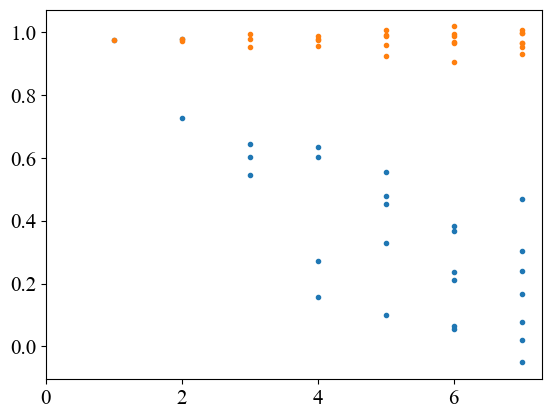

In [8]:
plt.plot(subsets, mi, '.')
plt.plot(inference_subsets, inference_mi, '.')
plt.gca().set_xlim(0)

# Precision


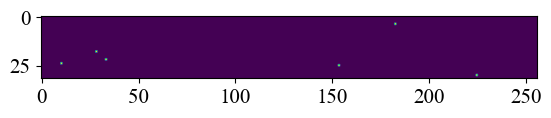

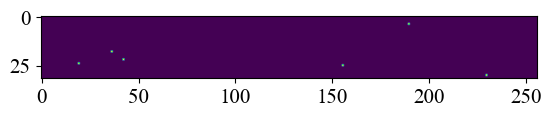

In [64]:
this_params = {**params, 'embed_dim': 10, 'batch_size': 256}
dataset = BatchedDatasetWithNoise(X.to(device), Y.to(device), this_params['batch_size'])

plt.figure()
dataset.apply_noise(0)
plt.imshow(dataset.Xnoise[0,0,:,:].cpu())
plt.figure()
dataset.apply_noise(0.001 / period)
plt.imshow(dataset.Xnoise[0,0,:,:].cpu())

In [ ]:
torch.cuda.empty_cache()
mod.eval()
amts = np.linspace(100,1500,10, dtype=int)
vals = np.zeros_like(amts)
with torch.no_grad():
    for i,amt in enumerate(amts):
        dataset.apply_noise(0)
        inds = np.random.choice(np.arange(dataset.Xnoise.shape[0]), amt)
        vals[i] = - mod(dataset.Xnoise[inds,:,:,:], dataset.Ynoise[inds,:,:,:])
plt.plot(amts, vals)

In [8]:
torch.mps.empty_cache()

# this_params = {**params, 'embed_dim': 10, 'window_size': 256}
torch.mps.synchronize()
tic = time.time()
dataset = BatchedDatasetWithNoise(X.to(device), Y.to(device), this_params['window_size'])
torch.mps.synchronize()
print(f'dataset = {time.time() - tic}')

n_repeats = 3
# noise_levels = torch.arange(period, 20*period, step=period).to(device)
noise_levels = torch.logspace(np.log10(period), np.log10(0.02), 20).to(device)
precision_mi = torch.zeros((len(noise_levels), n_repeats)).to(device)

mod.eval()

with torch.no_grad():
    for i,amp in enumerate(noise_levels):
        for j in range(n_repeats):
            dataset.apply_noise(amp / period)

            # inds = np.random.choice(np.arange(dataset.Xnoise.shape[0]), 2000)
            torch.mps.synchronize()
            tic = time.time()
            precision_mi[i,j] = -models[0](dataset.Xnoise, dataset.Ynoise).detach()
            torch.mps.synchronize()
            print(f'Inference: {time.time() - tic}')


dataset = 0.15633583068847656
Inference: 0.5941340923309326
Inference: 0.6205008029937744
Inference: 0.5042769908905029
Inference: 0.49620890617370605
Inference: 0.49607014656066895
Inference: 0.49566197395324707
Inference: 0.5053088665008545
Inference: 0.5037403106689453
Inference: 0.49646592140197754
Inference: 0.5309922695159912
Inference: 0.5017919540405273
Inference: 0.5031547546386719
Inference: 0.5056519508361816
Inference: 0.5065462589263916
Inference: 0.5328259468078613
Inference: 0.5059599876403809
Inference: 0.5154757499694824
Inference: 0.5013079643249512
Inference: 0.4972820281982422
Inference: 0.49623584747314453
Inference: 0.49387693405151367
Inference: 0.4951040744781494
Inference: 0.5004711151123047
Inference: 0.49389219284057617
Inference: 0.5356400012969971
Inference: 0.5194571018218994
Inference: 0.5167787075042725
Inference: 0.5145699977874756
Inference: 0.5240731239318848
Inference: 0.5170049667358398
Inference: 0.51226806640625
Inference: 0.5134811401367188
Infer

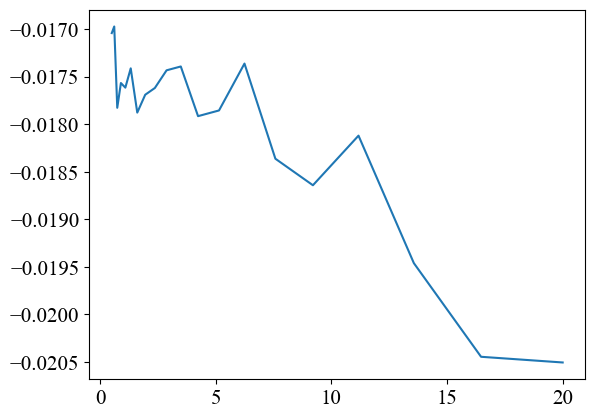

In [9]:
plt.plot(noise_levels.cpu() * 1000, torch.mean(precision_mi, dim=1).cpu())
# plt.gca().set_xscale('log')

# Precision estimation via training (not inference)

Re-training the model with different amounts of noise applied to the data

In [ ]:
params = {
    # Optimizer parameters (for training)
    'epochs': 250,
    'window_size': 256, # Window of time the estimator operates on, in samples
    'batch_size': 128, # Number of windows estimator processes at any time
    'learning_rate': 1e-3,
    'n_trials': 3,
    'patience': 30,
    'min_delta': 0.001,
    'eps': 1e-8, # Use 1e-4 if dtypes are float16, 1e-8 for float32 works okay
    'train_fraction': 0.9,
    # Critic parameters for DSIB or DVSIB (for the estimator), except embed_dim, which changes with training
    'model_func': DSIB, # DSIB or DVSIB
    'layers': 5,
    'fc_layers': 2, # fully connected layers, only for if using CNNs from data_form: 'image' 
    'hidden_dim': 512,
    'activation': nn.LeakyReLU, #nn.Softplus
    'beta': 512,
    'max_dz': 12, # max value for embed_dim that we search for
    'estimator': 'infonce', # Estimator: infonce or smile_5. See estimators.py for all options
    'data_form': 'image',
    'mode': 'sep', # Almost always we'll use separable
    'max_n_batches': 1000, # If input has more than this many batches, encoder runs are split up for memory management
}

neuron = 25

period = 0.0005
noise_range = np.hstack((0, np.logspace(np.log10(period), np.log10(0.01), 10) / period))
mi = np.zeros_like(np.array(noise_range))
mi_test = []
models = []
ids = []
# Precision curve params
precision_noise_levels = np.hstack((0, np.logspace(np.log10(period), np.log10(0.04), 40) / period))
n_repeats = 5
precision_curves = []

X, Y, x_labels, y_labels = read_spike_data(os.path.join(data_dir, '2025-03-21'), period)
X, Y = torch.tensor(X, dtype=default_dtype), torch.tensor(Y, dtype=default_dtype)

for i,noise_amp in enumerate(noise_range):
    torch.mps.empty_cache()
    this_params = {**params, 'embed_dim': 10}
    dataset = BatchedDatasetWithNoise(X[[neuron],:].to(device), Y.to(device), this_params['window_size'])
    mis_test, train_id = train_model_no_eval_apply_noise(dataset, this_params, model_cache_dir, noise_amp)
    mod = retrieve_best_model(model_cache_dir, mis_test, this_params, train_id=train_id)
    # Store results
    mi_test.append(mis_test)
    models.append(mod)
    ids.append(train_id)
    # Run inference
    with torch.no_grad():
        dataset.apply_noise(noise_amp)
        thismi = - mod(dataset.Xnoise, dataset.Ynoise)
        mi[i] = thismi.detach().cpu()
        # Precision curve for each 
        precision_mi = np.zeros((len(precision_noise_levels), n_repeats))
        for j0,prec_noise_amp in enumerate(precision_noise_levels):
            for j1 in range(n_repeats):
                dataset.apply_noise(prec_noise_amp)
                precision_mi[j0,j1] = - mod(dataset.Xnoise, dataset.Ynoise).detach().cpu().numpy()
        precision_curves.append(precision_mi)


Train time = 1.280348777770996
Test time = 0.154494047164917
Epoch: 1, DSIB, test: 0.1166582778096199
Train time = 1.273681879043579
Test time = 0.04385209083557129
Epoch: 2, DSIB, test: 0.18439489603042603
Train time = 1.2437896728515625
Test time = 0.0436711311340332
Epoch: 3, DSIB, test: 0.1823572814464569
Train time = 1.2447450160980225
Test time = 0.04325294494628906
Epoch: 4, DSIB, test: 0.23784030973911285
Train time = 1.2418811321258545
Test time = 0.044243812561035156
Epoch: 5, DSIB, test: 0.2471899688243866
Train time = 1.244704008102417
Test time = 0.04499697685241699
Epoch: 6, DSIB, test: 0.20079758763313293
Train time = 1.2425282001495361
Test time = 0.04319000244140625
Epoch: 7, DSIB, test: 0.11532793939113617
Train time = 1.2433910369873047
Test time = 0.04400205612182617
Epoch: 8, DSIB, test: 0.14835144579410553
Train time = 1.2450592517852783
Test time = 0.044033050537109375
Epoch: 9, DSIB, test: -0.09854907542467117
Train time = 1.2392871379852295
Test time = 0.044008

Text(0, 0.5, 'MI (bits/s)')

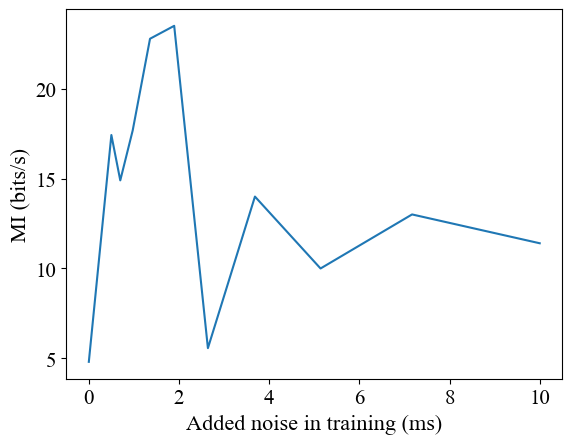

In [93]:
torch.mps.empty_cache()
plt.plot(noise_range * period * 1000, mi * np.log2(np.e) / params['window_size'] / period)
plt.gca().set_xlabel('Added noise in training (ms)')
plt.gca().set_ylabel('MI (bits/s)')

Text(0, 0.5, 'Measured precision (ms)')

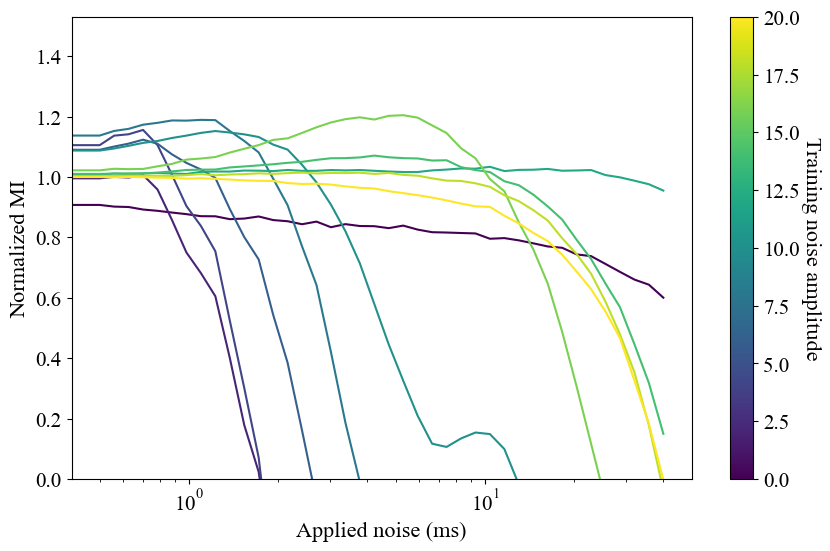

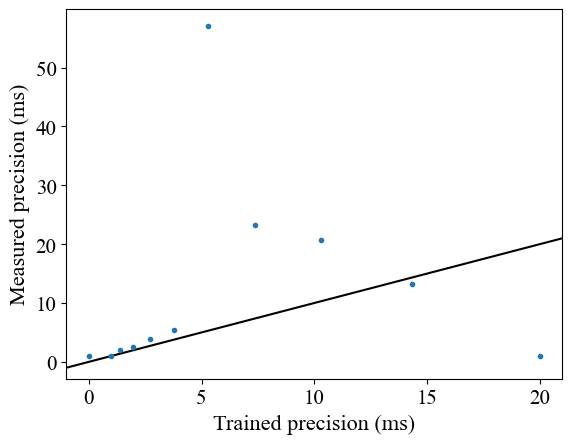

In [120]:
fig, ax = plt.subplots(figsize=(10, 6))
cmap = plt.cm.get_cmap('viridis')
for i in range(len(noise_range)):
    color_pos = i / (len(noise_range) - 1) if len(noise_range) > 1 else 0
    color = cmap(color_pos)
    vals = np.mean(precision_curves[i], axis=1) * np.log2(np.e) / params['window_size'] / period
    ax.plot(precision_noise_levels * period * 1000, vals / vals[0], color=color)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=noise_range[-1]))
sm.set_array([])  # Required for ScalarMappable
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Training noise amplitude', rotation=270, labelpad=15)
ax.set_xscale('log')
ax.set_ylim(0)
ax.set_xlabel('Applied noise (ms)')
ax.set_ylabel('Normalized MI')

fig, ax = plt.subplots()
precision = []
for curve in precision_curves:
    val = np.mean(curve, axis=1)
    val = val / val[0]
    precision.append(precision_noise_levels[np.argmax(val < 1)])

ax.axline([0,0], slope=1, color='k')
ax.plot(noise_range, np.array(precision),'.')
ax.set_xlabel('Trained precision (ms)')
ax.set_ylabel('Measured precision (ms)')

Text(0, 0.5, 'Normalized MI')

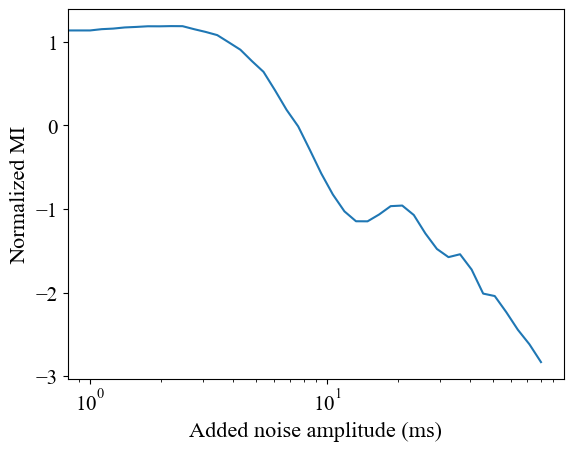

In [118]:
curve = np.mean(precision_curves[4], axis=1)
curve = curve / curve[0]
plt.plot(precision_noise_levels, curve)
curve
plt.gca().set_xscale('log')
plt.gca().set_xlabel('Added noise amplitude (ms)')
plt.gca().set_ylabel('Normalized MI')

# Vary dataset binning, see how it changes information learned/found

In [ ]:
params = {
    # Optimizer parameters (for training)
    'epochs': 250,
    'window_size': 512, # Window of time the estimator operates on, in samples
    'batch_size': 128, # Number of windows estimator processes at any time
    'learning_rate': 5e-3,
    'n_trials': 3,
    'patience': 15,
    'min_delta': 0.001,
    'eps': 1e-8, # Use 1e-4 if dtypes are float16, 1e-8 for float32 works okay
    'train_fraction': 0.9,
    # Critic parameters for DSIB or DVSIB (for the estimator), except embed_dim, which changes with training
    'model_func': DSIB, # DSIB or DVSIB
    'embed_dim': 10,
    'layers': 4,
    'fc_layers': 2, # fully connected layers, only for if using CNNs from data_form: 'image' 
    'hidden_dim': 512,
    'activation': nn.LeakyReLU, #nn.Softplus
    'beta': 512,
    'max_dz': 12, # max value for embed_dim that we search for
    'estimator': 'infonce', # Estimator: infonce or smile_5. See estimators.py for all options
    'data_form': 'image',
    'mode': 'sep', # Almost always we'll use separable
    'max_n_batches': 1000, # If input has more than this many batches, encoder runs are split up for memory management
}

neuron = 25

period_range = np.logspace(np.log10(0.00005), np.log10(0.01), 20)
mi_test = []
models = []
ids = []
precision_noise_levels = np.hstack((0, np.logspace(np.log10(period), np.log10(0.04), 40) / period))
n_repeats = 3
precision_curves = []
for i,period in enumerate(period_range):
    print(f'Period = {period} s')
    X, Y, x_labels, y_labels = read_spike_data(os.path.join(data_dir, '2025-03-21'), period)
    X, Y = torch.tensor(X, dtype=default_dtype), torch.tensor(Y, dtype=default_dtype)
    torch.mps.empty_cache()
    dataset = BatchedDatasetWithNoise(X[[neuron],:].to(device), Y.to(device), params['window_size'])
    mis_test, train_id = train_model_no_eval(dataset, params, model_cache_dir)
    mod = retrieve_best_model(model_cache_dir, mis_test, train_id=train_id, burn_in=1)
    # Store results
    mi_test.append(mis_test)
    models.append(mod)
    ids.append(train_id)
    with torch.no_grad():
        # Precision curve for each 
        precision_mi = np.zeros((len(precision_noise_levels), n_repeats))
        for j0,prec_noise_amp in enumerate(precision_noise_levels):
            for j1 in range(n_repeats):
                dataset.apply_noise(prec_noise_amp)
                precision_mi[j0,j1] = - mod(dataset.Xnoise, dataset.Ynoise).detach().cpu().numpy()
        precision_curves.append(precision_mi)


Period = 4.9999999999999996e-05 s
Train time = 8.385380744934082
Test time = 0.21169400215148926
Epoch: 1, DSIB, test: 0.006829846650362015
Train time = 7.9879150390625
Test time = 0.2163081169128418
Epoch: 2, DSIB, test: 0.03982722386717796
Train time = 7.946149826049805
Test time = 0.2069230079650879
Epoch: 3, DSIB, test: 0.03663326054811478
Train time = 7.95436692237854
Test time = 0.20759916305541992
Epoch: 4, DSIB, test: 0.04140667989850044
Train time = 7.903834342956543
Test time = 0.20545005798339844
Epoch: 5, DSIB, test: 0.04298585280776024
Train time = 7.910940885543823
Test time = 0.2080216407775879
Epoch: 6, DSIB, test: 0.03641291707754135
Train time = 7.91900110244751
Test time = 0.20574522018432617
Epoch: 7, DSIB, test: 0.03459368646144867
Train time = 7.93487286567688
Test time = 0.2082958221435547
Epoch: 8, DSIB, test: 0.035471778362989426
Train time = 7.982103109359741
Test time = 0.20671892166137695
Epoch: 9, DSIB, test: 0.04286494106054306
Train time = 7.9067850112915

In [32]:
n_repeats = 3
precision_curves = []
for i,period in enumerate(period_range):
    with torch.no_grad():
        X, Y, x_labels, y_labels = read_spike_data(os.path.join(data_dir, '2025-03-21'), period)
        X, Y = torch.tensor(X, dtype=default_dtype), torch.tensor(Y, dtype=default_dtype)
        torch.mps.empty_cache()
        precision_noise_levels = np.hstack((0, np.logspace(np.log10(period), np.log10(0.04), 40) / period))
        # Precision curve for each 
        precision_mi = np.zeros((len(precision_noise_levels), n_repeats))
        for j0,prec_noise_amp in enumerate(precision_noise_levels):
            for j1 in range(n_repeats):
                dataset.apply_noise(prec_noise_amp)
                precision_mi[j0,j1] = - models[i](dataset.Xnoise, dataset.Ynoise).detach().cpu().numpy()
        precision_curves.append(precision_mi)

Text(0, 0.5, 'MI (bits/s)')

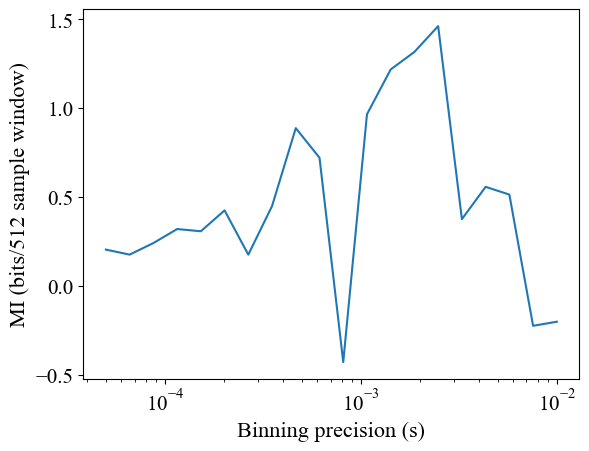

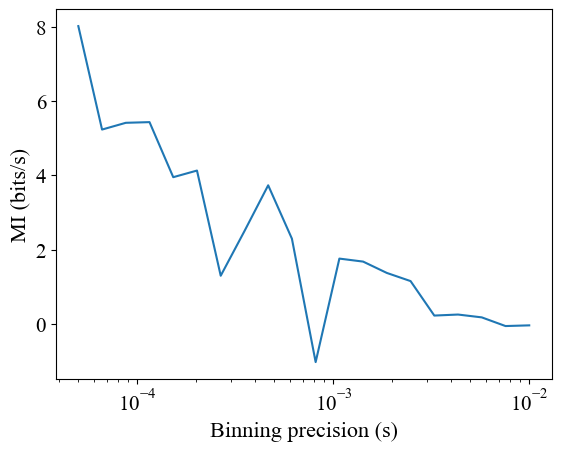

In [19]:
mi = np.array([np.mean(p[0,:]) for p in precision_curves])
plt.plot(np.array(period_range), mi * np.log2(np.e))
ax = plt.gca()
ax.set_xscale('log')
ax.set_xlabel('Binning precision (s)')
ax.set_ylabel('MI (bits/512 sample window)')

plt.figure()
plt.plot(np.array(period_range), mi * np.log2(np.e) / params['window_size'] / period_range)
ax = plt.gca()
ax.set_xscale('log')
ax.set_xlabel('Binning precision (s)')
ax.set_ylabel('MI (bits/s)')

In [42]:
period_range * 1000

array([ 0.05      ,  0.06608104,  0.08733407,  0.11542251,  0.15254479,
        0.20160635,  0.26644714,  0.35214206,  0.46539824,  0.61507997,
        0.81290243,  1.07434871,  1.41988152,  1.87654485,  2.48008057,
        3.2777259 ,  4.33191049,  5.7251427 ,  7.56646728, 10.        ])

Text(0, 0.5, 'Normalized MI')

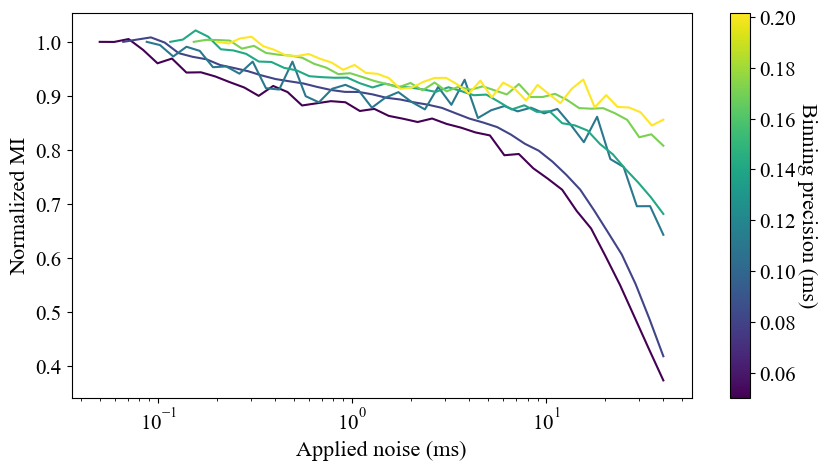

In [55]:
fig, ax = plt.subplots(figsize=(10,5))
cmap = plt.cm.get_cmap('viridis')
prange = period_range[0:6]
for i, period in enumerate(prange):
    precision_noise_levels = np.hstack((0, np.logspace(np.log10(period), np.log10(0.04), 40)))
    color_pos = i / (len(prange) - 1) if len(prange) > 1 else 0
    color = cmap(color_pos)
    vals = np.mean(precision_curves[i], axis=1) * np.log2(np.e) / params['window_size'] / period
    ax.plot(precision_noise_levels[1:] * 1000, vals[1:] / vals[1], color=color)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=prange[0]*1000, vmax=prange[-1]*1000))
sm.set_array([])  # Required for ScalarMappable
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Binning precision (ms)', rotation=270, labelpad=15)
ax.set_xscale('log')
# ax.set_ylim()
ax.set_xlabel('Applied noise (ms)')
ax.set_ylabel('Normalized MI')

Text(0, 0.5, 'Normalized MI')

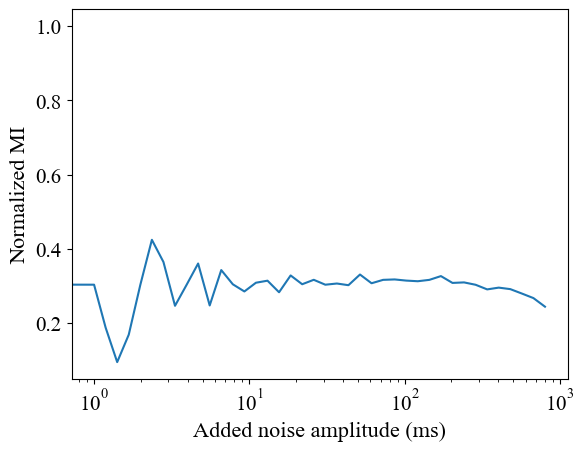

In [18]:
curve = np.mean(precision_curves[0], axis=1)
curve = curve / curve[0]
plt.plot(precision_noise_levels, curve)
curve
plt.gca().set_xscale('log')
plt.gca().set_xlabel('Added noise amplitude (ms)')
plt.gca().set_ylabel('Normalized MI')

In [26]:
from tqdm.auto import tqdm
# Empty arrays and do the run, will take forever
mi = {}
mi_test = {}
models = {}
ids = {}
batch_size_range = np.array([128, 256, 512, 1024])
neuron = np.random.choice(X.shape[0])

for bs in batch_size_range:
    for dz in tqdm(range(1, params['max_dz']+1)):
        print(f'Starting dz = {dz}')
        for j in range(params['n_trials']):
            this_params = {**params, 'embed_dim': dz, 'batch_size': bs}
            print(f'batch size = {bs}, dz = {dz}, trial = {j+1}')
            torch.cuda.empty_cache()
            dataset = BatchedDataset(X[[neuron],:], Y, this_params['batch_size'])
            full_dataset = create_cnn_data_split(dataset, 60, train_fraction=0.9, eval_fraction=0.9, device=device)
            mis, mis_test, _ = train_cnn_model(DSIB, full_dataset, this_params)
            # full_dataset = create_cnn_data_split(dataset, train_fraction=0.9, eval_fraction=0.9, device=device)
            # mis, mis_test = train_model(DSIB, full_dataset, this_params)
            # mis_test, train_id = train_model_no_eval(DSIB, full_dataset, this_params, model_cache_dir)
            # mod = retrieve_best_model(model_cache_dir, mis_test, train_id=train_id, burn_in=1)
            # Store results
            key = f"trial_{j}_dz_{dz}_bs_{bs}"
            mi[key] = mis
            mi_test[key] = mis_test
            # models[key] = mod
            # ids[key] = train_id
torch.cuda.empty_cache()


  0%|          | 0/12 [00:00<?, ?it/s]

Starting dz = 1
batch size = 128, dz = 1, trial = 1
Train time = 0.7406737804412842
Eval time = 0.016013622283935547
Test time = 0.005005598068237305
Epoch: 1, DSIB, train: -8.574826097174082e-06, test: -8.78915216162568e-06
Train time = 0.5104649066925049
Eval time = 0.002001047134399414
Test time = 0.002002716064453125
Epoch: 2, DSIB, train: -3.644090156740276e-06, test: -3.7664101455447963e-06
Train time = 0.5234763622283936
Eval time = 0.002001523971557617
Test time = 0.002003192901611328
Epoch: 3, DSIB, train: -1.7990419109992217e-06, test: -2.378149929427309e-06
Train time = 0.5004549026489258
Eval time = 0.002001523971557617
Test time = 0.002003192901611328
Epoch: 4, DSIB, train: -1.598914082023839e-06, test: -1.5391580063806032e-06
Train time = 0.5214755535125732
Eval time = 0.002002716064453125
Test time = 0.001001119613647461
Epoch: 5, DSIB, train: -8.14888323930063e-07, test: -1.0640453638188774e-06
Train time = 0.5054595470428467
Eval time = 0.002002716064453125
Test time =

  0%|          | 0/12 [00:00<?, ?it/s]

Starting dz = 1
batch size = 256, dz = 1, trial = 1
Train time = 0.43439412117004395
Eval time = 0.01401376724243164
Test time = 0.005004405975341797
Epoch: 1, DSIB, train: -0.00040275955689139664, test: -0.00039908778853714466
Train time = 0.45641469955444336
Eval time = 0.002002239227294922
Test time = 0.0009999275207519531
Epoch: 2, DSIB, train: -2.252435115224216e-05, test: -2.9693497708649375e-05
Train time = 0.4253857135772705
Eval time = 0.0020024776458740234
Test time = 0.002001047134399414
Epoch: 3, DSIB, train: -3.789873744608485e-06, test: -5.052479991718428e-06
Train time = 0.42738842964172363
Eval time = 0.0020017623901367188
Test time = 0.003002643585205078
Epoch: 4, DSIB, train: -1.6487376797158504e-06, test: -1.6182557374122553e-06
Train time = 0.4263877868652344
Eval time = 0.002187490463256836
Test time = 0.0010008811950683594
Epoch: 5, DSIB, train: -1.8684459064388648e-06, test: -1.3424544249573955e-06
Train time = 0.4133765697479248
Eval time = 0.002000570297241211


  0%|          | 0/12 [00:00<?, ?it/s]

Starting dz = 1
batch size = 512, dz = 1, trial = 1
Train time = 0.6295723915100098
Eval time = 0.016015052795410156
Test time = 0.007005929946899414
Epoch: 1, DSIB, train: -0.01148455310612917, test: -0.01034874189645052
Train time = 0.6191556453704834
Eval time = 0.0030028820037841797
Test time = 0.0020017623901367188
Epoch: 2, DSIB, train: -0.00048147584311664104, test: -0.00042977623525075614
Train time = 0.6265697479248047
Eval time = 0.0020020008087158203
Test time = 0.0010004043579101562
Epoch: 3, DSIB, train: -6.341320113278925e-05, test: -6.500879680970684e-05
Train time = 0.6385796070098877
Eval time = 0.0020020008087158203
Test time = 0.0020020008087158203
Epoch: 4, DSIB, train: -1.6865586076164618e-05, test: -1.9105924366158433e-05
Train time = 0.6155598163604736
Eval time = 0.002002239227294922
Test time = 0.0020017623901367188
Epoch: 5, DSIB, train: -1.0816255780810025e-05, test: -1.3565530025516637e-05
Train time = 0.6215651035308838
Eval time = 0.0020024776458740234
Tes

  0%|          | 0/12 [00:00<?, ?it/s]

Starting dz = 1
batch size = 1024, dz = 1, trial = 1
Train time = 0.5445020198822021
Eval time = 0.020017385482788086
Test time = 0.00600433349609375
Epoch: 1, DSIB, train: -0.012846967205405235, test: -0.01035755593329668
Train time = 0.5034575462341309
Eval time = 0.0020012855529785156
Test time = 0.002001523971557617
Epoch: 2, DSIB, train: -0.005014576483517885, test: -0.00434390502050519
Train time = 0.5044593811035156
Eval time = 0.0030014514923095703
Test time = 0.002002716064453125
Epoch: 3, DSIB, train: -0.0008515996159985662, test: -0.0006777612725272775
Train time = 0.5054595470428467
Eval time = 0.0020017623901367188
Test time = 0.002001523971557617
Epoch: 4, DSIB, train: -8.7614098447375e-05, test: -7.642570562893525e-05
Train time = 0.5024571418762207
Eval time = 0.0020017623901367188
Test time = 0.001001119613647461
Epoch: 5, DSIB, train: -5.419558874564245e-06, test: -4.655436441680649e-06
Train time = 0.5024561882019043
Eval time = 0.002001523971557617
Test time = 0.002

KeyError: 'trial_0_dz_1_bs_20'

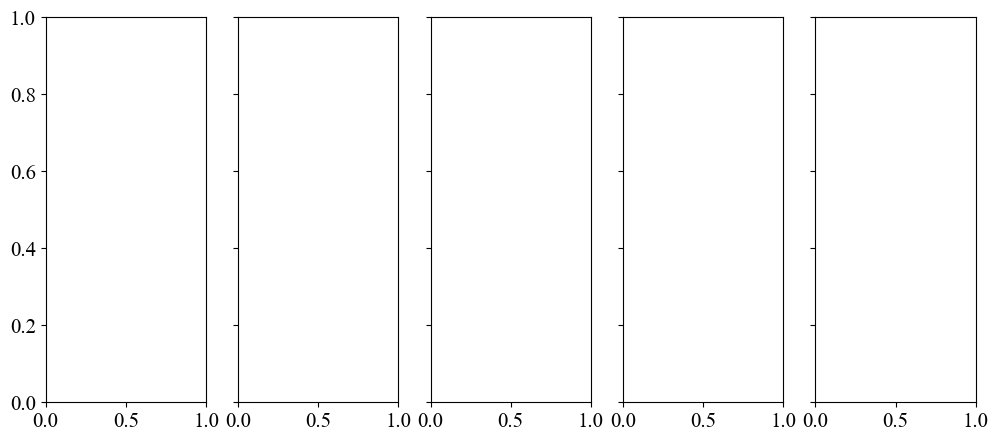

In [34]:
# Define sigma, a small number is usually the best choice
sigma=1 # (or 2 at most)

fig, ax = plt.subplots(1, len(batch_size_range), figsize=(12,5), sharey=True)
for i,bs in enumerate(batch_size_range):    
    dz_means, dz_stds = [], []
    dz_train_means, dz_train_stds = [], []
    for dz in range(1, params['max_dz']+1):
        mi_trials = []
        mi_train = []
        for j in range(params['n_trials']):
            key = f"trial_{j}_dz_{dz}_bs_{bs}"
            # Convert Nan to zeros and smooth
            # test = gaussian_filter1d(np.nan_to_num(mi_test[key]), sigma=sigma) / bs * np.log2(np.e) * 1000
            train = gaussian_filter1d(np.nan_to_num(mi[key]), sigma=sigma) * np.log2(np.e) #/ (0.0005 * bs)
            test = gaussian_filter1d(np.nan_to_num(mi_test[key]), sigma=sigma) * np.log2(np.e) #/ (0.0005 * bs)
            # Pick the epoch with highest test value and get corresponding train
            best = np.argmax(test)
            mi_trials.append(test[best])
            mi_train.append(train[best])
        dz_means.append(np.mean(np.array(mi_trials)).flatten())
        dz_stds.append(np.std(np.array(mi_trials)).flatten())
        dz_train_means.append(np.mean(np.array(mi_train)).flatten())
        dz_train_stds.append(np.std(np.array(mi_train)).flatten())
    b = ax[i].errorbar(
        range(1, params['max_dz']+1), np.array(dz_means).flatten(), 
        yerr=np.array(dz_stds).flatten(), 
        fmt='s:', capsize=4)
    # ax[i].errorbar(
    #     range(1, params['max_dz']+1), np.array(dz_train_means).flatten(), 
    #     yerr=np.array(dz_train_stds).flatten(), 
    #     fmt='s:', capsize=4)

    # Set title and scales
    ax[i].set_title(str(bs))
    ax[i].set_xlabel(r'$dz$')
    if i == 0:
        ax[i].set_ylabel(r'$I(X;Y) \text{(bits/s)}$');
    # ax[i].set_ylim(-1, 4)


trial_0_dz_10_bs_64


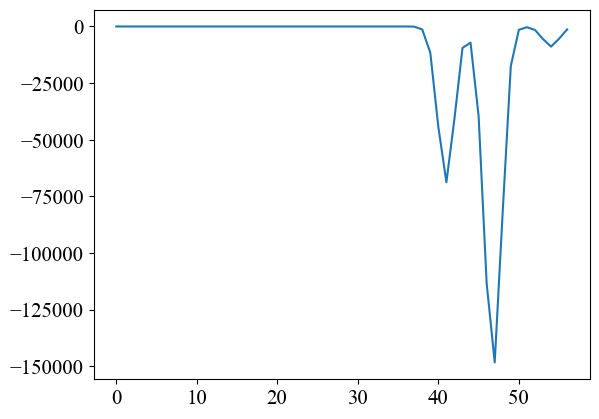

In [72]:
key = random.choice(list(mi_test.keys()))
sigma = 1
# plt.plot(gaussian_filter1d(np.nan_to_num(mi[key]), sigma=sigma))
plt.plot(gaussian_filter1d(np.nan_to_num(mi_test[key]) * np.log2(np.e), sigma=sigma))
# plt.gca().set_ylim(0)
print(key)

In [82]:
import pickle

with open(os.path.join(main_dir, 'mi_test_2025-04-27.pkl'), 'wb') as f:
    pickle.dump(mi_test, f)
with open(os.path.join(main_dir, 'ids_2025-04-27.pkl'), 'wb') as f:
    pickle.dump(ids, f)


In [91]:
ids

{'trial_0_dz_5_bs_64': 'DSIB_dz-5_bs-64_8fd6f693-0e8c-4050-80f0-71743727faf4',
 'trial_1_dz_5_bs_64': 'DSIB_dz-5_bs-64_53c1ac4c-c23f-4fb7-b0de-03609854555d',
 'trial_2_dz_5_bs_64': 'DSIB_dz-5_bs-64_980c7b88-ae7e-45c8-8654-43988f324259',
 'trial_0_dz_6_bs_64': 'DSIB_dz-6_bs-64_f5780180-bfd3-435e-b811-ea7695d4a1b5',
 'trial_1_dz_6_bs_64': 'DSIB_dz-6_bs-64_bd177624-0f1d-47e3-9b66-3efe1affcb26',
 'trial_2_dz_6_bs_64': 'DSIB_dz-6_bs-64_e444d9e9-1f41-4509-8b87-95f2bcb4c6ba',
 'trial_0_dz_7_bs_64': 'DSIB_dz-7_bs-64_9dc5f773-c58a-41b1-8d58-f154bc18fe83',
 'trial_1_dz_7_bs_64': 'DSIB_dz-7_bs-64_136f4efa-0772-4a42-b8d1-163fcca65eda',
 'trial_2_dz_7_bs_64': 'DSIB_dz-7_bs-64_aa666a3e-dd74-47c8-9e75-a2260fe347af',
 'trial_0_dz_8_bs_64': 'DSIB_dz-8_bs-64_aaf1e6a7-8d80-4aba-bfe0-8fc840cb522f',
 'trial_1_dz_8_bs_64': 'DSIB_dz-8_bs-64_ef96a2d7-2bcc-45d7-b9ec-20ad29bfc0a7',
 'trial_2_dz_8_bs_64': 'DSIB_dz-8_bs-64_b53fd0ff-c038-4b42-b96d-2a9a32ea69e8',
 'trial_0_dz_9_bs_64': 'DSIB_dz-9_bs-64_6ce81eb9-0f7

In [ ]:
with open(os.path.join(main_dir, 'mi_test_2025-04-27.pkl'), 'rb') as f:
    bob = pickle.load(f)
with open(os.path.join(main_dir, 'ids_2025-04-27.pkl'), 'rb') as f:
    bob = pickle.load(f)

Okay, so running on the whole dataset takes a long time. 


Scheme for a given moth:
- X embedding dimension sizes
- Y repeats at each embedding dim size
- Z batch sizes